# Convolutional Neural Networks

In this notebook, we will implement LeNet-5, AlexNet and VGG-16 archtectures and test them on the Tiny Imagenet Dataset.

### Import Statements

In [ ]:


!unzip /content/drive/MyDrive/tiny-imagenet-200.zip




In [3]:
#print (torch.__version__)

In [19]:
import numpy as np
import os
from datetime import datetime 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

from torchvision import datasets, transforms

import matplotlib.pyplot as plt

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print (DEVICE)

cuda


### Global Variables

In [3]:
# Global Variables
BATCH_SIZE = 64
LEARNING_RATE = 0.001
N_EPOCHS = 120
RANDOM_SEED = 32

N_CLASSES = 200

### Get Data

In [4]:
# Path to train, test and val data
here = os.path.dirname(os.path.realpath('__file__'))
subdir = "tiny-imagenet-200"
test_dir = os.path.join(here, subdir, "test")
train_dir = os.path.join(here, subdir, "train")
val_dir = os.path.join(here, subdir, "val")

### Run Models

In [5]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='green', label='Training loss') 
    ax.plot(valid_losses, color='orange', label='Testing loss')
    ax.set(title="Loss across epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('ggplot')

def train_optm (train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

def training_loop_optm (model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
 
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train_optm (train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
                
            print(f'{datetime.now().time().replace(microsecond=0)}     '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.3f}\t'
                  f'Test loss: {valid_loss:.3f}\t'
                  f'Train accuracy: {100 * train_acc:.3f}\t'
                  f'Test accuracy: {100 * valid_acc:.3f}')
            
    plot_losses(train_losses, valid_losses)
    
    return model, optimizer, (train_losses, valid_losses)



## LeNet-5

Here we implement one of the first CNNs, LeNet-5, on the Tiny Imagenet dataset and look at training and validation accuracies across epochs. We further optimize it using ADAM optimization.

### Transform data for LeNet-5

In [8]:
# Transform images into 32 pixels x 32 pixels as reqd by LeNet-5
mean = (0.48093379, 0.44808328, 0.39650237)
stddev = (0.22996924, 0.22610814, 0.22566715)
my_trans = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor(), transforms.Normalize(mean, stddev)])

# Make dataset objects
#test_data = datasets.ImageFolder (test_dir, transform = my_trans)
tot_data = datasets.ImageFolder (train_dir, transform = my_trans)
#print (len(tot_data[0][0][0][0]))
train_data, val_data = random_split (tot_data, [90000, 10000])
#print (len(val_data[0][0]))
#val_data = datasets.ImageFolder (val_dir, transform = my_trans)
#test_load = DataLoader (dataset=test_data, batch_size=BATCH_SIZE, shuffle=True)
train_load = DataLoader (dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
val_load = DataLoader (dataset=val_data, batch_size=BATCH_SIZE, shuffle=True)

### LeNet-5 Class

In [56]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

### Intialize LeNet-5

In [57]:

torch.manual_seed(RANDOM_SEED)

model = LeNet5(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

### LeNet-5 with optimizer

06:22:01     Epoch: 9	Train loss: 3.980	Test loss: 4.231	Train accuracy: 16.461	Test accuracy: 11.960
06:31:22     Epoch: 19	Train loss: 3.740	Test loss: 4.292	Train accuracy: 19.969	Test accuracy: 11.780
06:40:38     Epoch: 29	Train loss: 3.595	Test loss: 4.407	Train accuracy: 21.654	Test accuracy: 11.850
06:49:53     Epoch: 39	Train loss: 3.493	Test loss: 4.490	Train accuracy: 23.994	Test accuracy: 11.650
06:59:09     Epoch: 49	Train loss: 3.417	Test loss: 4.574	Train accuracy: 25.329	Test accuracy: 10.770
07:08:23     Epoch: 59	Train loss: 3.350	Test loss: 4.656	Train accuracy: 26.612	Test accuracy: 10.540
07:17:38     Epoch: 69	Train loss: 3.301	Test loss: 4.748	Train accuracy: 26.933	Test accuracy: 10.080
07:26:54     Epoch: 79	Train loss: 3.253	Test loss: 4.820	Train accuracy: 27.226	Test accuracy: 9.750
07:36:14     Epoch: 89	Train loss: 3.218	Test loss: 4.892	Train accuracy: 27.147	Test accuracy: 9.440
07:45:37     Epoch: 99	Train loss: 3.183	Test loss: 4.935	Train accuracy: 28

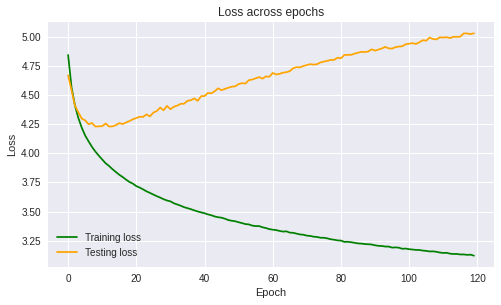

In [58]:
model, optimizer, _ = training_loop_optm (model, criterion, optimizer, train_load, val_load, N_EPOCHS, DEVICE, print_every = 10)

## AlexNet

### Transform data (AlexNet and VGG-16)

In [54]:
# Preprocess image
my_trans = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize(mean, stddev),
])

# Make dataset objects
#test_data = datasets.ImageFolder (test_dir, transform = my_trans)
#val_data = datasets.ImageFolder (val_dir, transform = my_trans)
tot_data = datasets.ImageFolder (train_dir, transform = my_trans)
test_data, val_data = random_split (tot_data, [90000, 10000])
test_load = DataLoader (dataset=test_data, batch_size=BATCH_SIZE, 
                          shuffle=True)
#print (len(tot_data[0][0][0]))
train_load = DataLoader (dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
val_load = DataLoader (dataset=val_data, batch_size=BATCH_SIZE, 
                          shuffle=True)

### AlexNet Class

In [51]:
class AlexNet(nn.Module):

    def __init__(self, num_classes: int = 1000) -> None:
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            #nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256*6*6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        out = torch.flatten(x, 1)
        logit = self.classifier(out)
        probs = F.softmax(logit, dim=1)
        return logit, probs

### Initialize AlexNet

In [52]:
torch.manual_seed(RANDOM_SEED)

model = AlexNet (N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

### AlexNet with Adam optimizer

In [ ]:
model, optimizer, _ = training_loop_optm (model, criterion, optimizer, train_load, val_load, N_EPOCHS, DEVICE, print_every = 1)

#VGG-16

## VGG-16 class

In [44]:
def conv_layer(chann_in, chann_out, k_size, p_size):
    layer = nn.Sequential(
        nn.Conv2d(chann_in, chann_out, kernel_size=k_size, padding=p_size),
        nn.BatchNorm2d(chann_out),
        nn.ReLU()
    )
    return layer

def vgg_conv_block(in_list, out_list, k_list, p_list, pooling_k, pooling_s):

    layers = [ conv_layer(in_list[i], out_list[i], k_list[i], p_list[i]) for i in range(len(in_list)) ]
    layers += [ nn.MaxPool2d(kernel_size = pooling_k, stride = pooling_s)]
    return nn.Sequential(*layers)

def vgg_fc_layer(size_in, size_out):
    layer = nn.Sequential(
        nn.Linear(size_in, size_out),
        nn.BatchNorm1d(size_out),
        nn.ReLU()
    )
    return layer

class VGG16(nn.Module):
    def __init__(self, n_classes=1000):
        super(VGG16, self).__init__()

        # Conv blocks (BatchNorm + ReLU activation added in each block)
        self.layer1 = vgg_conv_block([3,64], [64,64], [3,3], [1,1], 2, 2)
        self.layer2 = vgg_conv_block([64,128], [128,128], [3,3], [1,1], 2, 2)
        self.layer3 = vgg_conv_block([128,256,256], [256,256,256], [3,3,3], [1,1,1], 2, 2)
        self.layer4 = vgg_conv_block([256,512,512], [512,512,512], [3,3,3], [1,1,1], 2, 2)
        self.layer5 = vgg_conv_block([512,512,512], [512,512,512], [3,3,3], [1,1,1], 2, 2)

        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

        # FC layers
        self.layer6 = vgg_fc_layer(7*7*512, 4096)
        self.layer7 = vgg_fc_layer(4096, 4096)

        # Final layer
        self.layer8 = nn.Linear(4096, n_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        probs = F.softmax(out, dim=1)
        return out, probs


### VGG-16 initialization

In [45]:
torch.manual_seed(RANDOM_SEED)

model = VGG16(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

### VGG-16 with optimizer

In [ ]:
model, optimizer, _ = training_loop_optm (model, criterion, optimizer, train_load, val_load, N_EPOCHS, DEVICE, print_every = 1)